In [1]:
from collections import OrderedDict
import torch
import torch.nn.functional as F

import nnsight
from nnsight import NNsight

from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

from nnsight import LanguageModel

import numpy as np
from scipy.spatial.distance import cosine, euclidean

import matplotlib.pyplot as plt
import seaborn as sns

# Model inizialization

+ **wte** = word token embedding  [num_tokens, emb_dim]
    + 50257 vocab dim 
    + 768 embedding dim

+ **wpe** = word position embedding [num_tokens, emb_dim]
    + 1024 max sequence lenght
    + 768 embedding dim 

<p align="left">
    <strong>residual = wte + wpe</strong>
</p>


LLM Visualization https://bbycroft.net/llm

In [2]:
#Model Initialization
llm = LanguageModel("openai-community/gpt2", device_map="cuda")#, device_map="auto")

print(llm)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): Generator(
    (streamer): Streamer()
  )
)


# Inputs

In [3]:
# Input string
text = "The Eiffel Tower is in the city of"
# High variance text
high_variance_text = """The quantum mechanics lecture covered topics from wave-particle duality 
to Schrödinger's cat, while the culinary class next door was busy preparing a variety of exotic dishes."""

# Low variance text
low_variance_text = """The cat sat on the mat, purring softly as it basked in the warm sunlight streaming 
through the window."""



print(f"Number of GPT tokens in text: {len(llm.tokenizer.encode(text))}")

print(f"Number of GPT tokens in high variance text: {len(llm.tokenizer.encode(high_variance_text))}")
print(f"Number of GPT tokens in low variance text: {len(llm.tokenizer.encode(low_variance_text))}")

Number of GPT tokens in text: 10
Number of GPT tokens in high variance text: 38
Number of GPT tokens in low variance text: 25


In [4]:
llm.tokenizer.encode(text)

[464, 412, 733, 417, 8765, 318, 287, 262, 1748, 286]

# Model - nnsight

In [5]:
with llm.trace(text):

    # Access the last layer using h[-1] as it's a ModuleList
    # Access the first index of .output as that's where the hidden states are.

    token_embed = llm.transformer.wte.output.save()    
    pos_embed = llm.transformer.wpe.output.save()
    input_embed = llm.transformer.drop.input.save()
    #llm.transformer.h[-1].mlp.output[0][:] = 0
    ln_0 = llm.transformer.h[0].ln_1.output.save()
    #attn_0 = llm.transformer.h[0].attn.output.save()

    # Logits come out of model.lm_head and we apply argmax to get the predicted token ids.
    token_ids = llm.lm_head.output.argmax(dim=-1).save()

print("\nToken IDs:", token_ids)
print("type:", type(token_embed))

# Apply the tokenizer to decode the ids into words after the tracing context.
print("Prediction:", llm.tokenizer.decode(token_ids[0][-1]))


Token IDs: tensor([[ 198,   12,  417, 8765,  318,  257,  262, 3504, 7372, 6342]],
       device='cuda:0')
type: <class 'torch.Tensor'>
Prediction:  Paris


In [6]:
#Prediction for each input token
for i, id in enumerate(token_ids[0]):
    print(llm.tokenizer.decode(llm.tokenizer.encode(text)[i]), "--->",  llm.tokenizer.decode(id))

The ---> 

 E ---> -
iff ---> el
el --->  Tower
 Tower --->  is
 is --->  a
 in --->  the
 the --->  middle
 city --->  centre
 of --->  Paris


In [7]:
ln_0.shape

torch.Size([1, 10, 768])

# Check embedding 

In [8]:
token_embed.shape, pos_embed.shape

(torch.Size([1, 10, 768]), torch.Size([1, 10, 768]))

In [9]:
residual_input = token_embed + pos_embed

In [10]:
input_embed.shape, token_embed.shape, residual_input.shape, torch.equal(residual_input, input_embed)

(torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]),
 True)

In [11]:
input_embed.shape, input_embed[0].shape

(torch.Size([1, 10, 768]), torch.Size([10, 768]))

# Results
text --> 0.046019245  



### Cosine Similarity

+ **Normalization**: Normalizing vectors to unit length ensures that cosine similarity measures directional similarity, independent of vector magnitudes.
+ **Cosine of the Angle**: Cosine similarity calculates the cosine of the angle between two vectors, focusing on their direction.
+ **Focus on Direction**: By normalizing vectors, we remove the influence of their lengths, allowing cosine similarity to purely measure how aligned the vectors are in terms of direction.



Mean Cosine Similarity: 0.6848686933517456


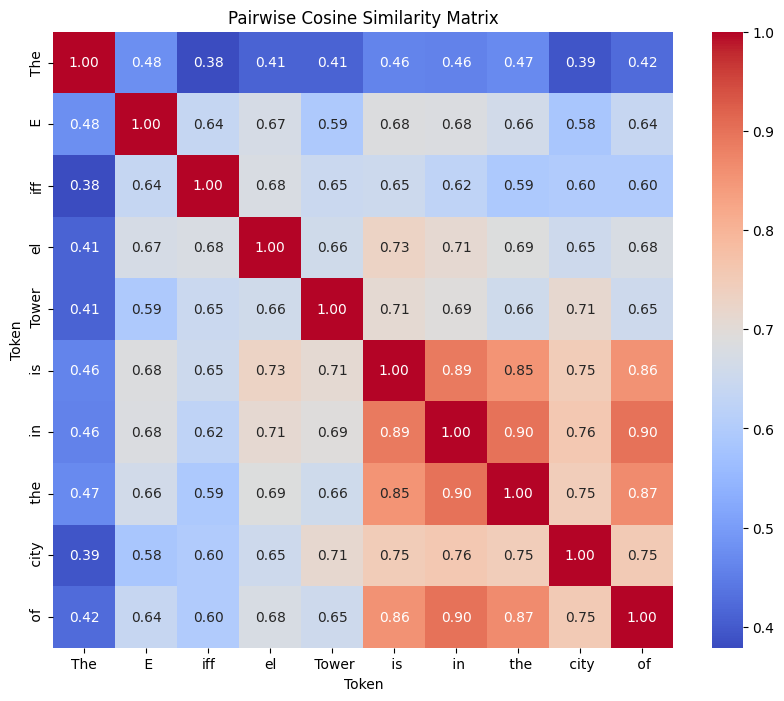

In [12]:
def calculate_cosine_similarity_matrix(input_embed):
    input_embed_norm = F.normalize(input_embed[0], p=2, dim=1) # L2 normalization
    cosine_similarity_matrix = torch.mm(input_embed_norm, input_embed_norm.t())
    return cosine_similarity_matrix

def plot_pairwise_matrix(pairwise_matrix, text):
    tokens_eiffel = llm.tokenizer.encode(text)
    tokens_str_eiffel = [llm.tokenizer.decode(tokens_eiffel[i]) for i in range(len(tokens_eiffel))]
    plt.figure(figsize=(10, 8))
    sns.heatmap(pairwise_matrix.cpu().detach().numpy(), annot=True, cmap='coolwarm', fmt=".2f", xticklabels=tokens_str_eiffel, yticklabels=tokens_str_eiffel)
    plt.title("Pairwise Cosine Similarity Matrix")
    plt.xlabel("Token")
    plt.ylabel("Token")
    plt.show()

# Main function to execute the steps
def main(llm, text):
    with llm.trace(text):
        input_embed = llm.transformer.drop.input.save()

    cosine_similarity_matrix = calculate_cosine_similarity_matrix(input_embed)
    
    print(f"Mean Cosine Similarity: {torch.mean(cosine_similarity_matrix)}")     
    plot_pairwise_matrix(cosine_similarity_matrix, text)

# Call the main function
main(llm, text)



In [13]:
#check
cosine_sim_0_1 = F.cosine_similarity(input_embed[0][0], input_embed[0][1], dim=0)
cosine_sim_0_2 = F.cosine_similarity(input_embed[0][0], input_embed[0][2], dim=0)
cosine_sim_0_1, cosine_sim_0_2

(tensor(0.4774, device='cuda:0', grad_fn=<SumBackward1>),
 tensor(0.3789, device='cuda:0', grad_fn=<SumBackward1>))

In [14]:
with llm.trace(text):
    input_embed = llm.transformer.drop.input.save()


embedding_variance = torch.var(input_embed[0], dim=1, unbiased=False)

# Calculate the mean variance across all dimensions
mean_variance = torch.mean(embedding_variance)

print(f"Embedding variance: {embedding_variance}")
print(f"Embedding variance shape: {embedding_variance.shape}")
print(f"Mean variance: {mean_variance}")

Embedding variance: tensor([0.1336, 0.0435, 0.0490, 0.0412, 0.0415, 0.0306, 0.0292, 0.0301, 0.0327,
        0.0286], device='cuda:0', grad_fn=<VarBackward0>)
Embedding variance shape: torch.Size([10])
Mean variance: 0.046016234904527664


In [15]:
with llm.trace(text):

    #token_embed = llm.transformer.wte.output.save()    
    #pos_embed = llm.transformer.wpe.output.save()
    input_embed = llm.transformer.drop.input.save()


embeddings = input_embed[0].cpu().detach().numpy()
# Initialize matrices to store distances
cosine_distances = np.zeros((len(embeddings), len(embeddings)))
euclidean_distances = np.zeros((len(embeddings), len(embeddings)))

# Calculate pairwise cosine and Euclidean distances
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        if i != j:  # Skip distance calculation for the same elements
            cosine_distances[i, j] = cosine(embeddings[i], embeddings[j])
            euclidean_distances[i, j] = euclidean(embeddings[i], embeddings[j])

print("Cosine Distances:")
print(cosine_distances)

print("\nEuclidean Distances:")
print(euclidean_distances)
print(euclidean_distances.shape)

Cosine Distances:
[[0.         0.52263713 0.62112415 0.58737725 0.58948135 0.53936911
  0.54122561 0.52910638 0.60750526 0.57628381]
 [0.52263713 0.         0.36189747 0.32896525 0.40534872 0.31518441
  0.31565583 0.33754086 0.41616577 0.36109537]
 [0.62112415 0.36189747 0.         0.32251143 0.35266489 0.34703594
  0.37517387 0.40892595 0.40269136 0.40139425]
 [0.58737725 0.32896525 0.32251143 0.         0.34158105 0.27142078
  0.29008991 0.31264091 0.34585744 0.32484031]
 [0.58948135 0.40534872 0.35266489 0.34158105 0.         0.29297113
  0.30712503 0.3429631  0.28757381 0.34642351]
 [0.53936911 0.31518441 0.34703594 0.27142078 0.29297113 0.
  0.11130202 0.14600396 0.24997151 0.14352602]
 [0.54122561 0.31565583 0.37517387 0.29008991 0.30712503 0.11130202
  0.         0.09979635 0.24119663 0.09956002]
 [0.52910638 0.33754086 0.40892595 0.31264091 0.3429631  0.14600396
  0.09979635 0.         0.25449061 0.13355356]
 [0.60750526 0.41616577 0.40269136 0.34585744 0.28757381 0.24997151
  